# Data Analytics for Health - Task 1.2.1: Data Preparation and Transformation

## Overview
This notebook prepares the consolidated patient profile for clustering analysis by:
- Handling missing values
- Identifying and handling outliers
- Applying data transformations (z-normalization)
- Performing feature selection (removing redundant features)

## Objectives
- Clean and prepare the final patient profile
- Ensure data quality for clustering algorithms
- Create normalized dataset ready for analysis

## Prerequisites
**IMPORTANT:** This notebook requires the output from `1.2.3_consolidate_features.ipynb`.
Please run `1.2.3_consolidate_features.ipynb` first to generate `1.2.3_final_patient_profile.csv`.

---


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from scipy import stats
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Set up file paths
notebook_dir = Path.cwd().resolve()
data_path = (notebook_dir / '..' / 'Data').resolve()

print("Libraries imported successfully")
print(f"Data path: {data_path}")


Libraries imported successfully
Data path: /Users/alexandermittet/Library/Mobile Documents/com~apple~CloudDocs/uni_life/UniPi DAD/data_analytics_4_health_unipi/Data


## 1. Load Consolidated Patient Profile


In [5]:
# Load consolidated patient profile
profile_file = data_path / '1.2.3_final_patient_profile.csv'

if not profile_file.exists():
    raise FileNotFoundError(
        f"\n{'='*80}\n"
        f"ERROR: Required file not found!\n"
        f"{'='*80}\n"
        f"File: {profile_file}\n\n"
        f"Please run '1.2.3_consolidate_features.ipynb' first to generate this file.\n"
        f"{'='*80}"
    )

df = pd.read_csv(profile_file)

print(f"Loaded patient profile: {df.shape[0]:,} subjects × {df.shape[1]} features")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()


Loaded patient profile: 4,392 subjects × 16 features

Columns: ['subject_id', 'gender', 'n_lab_events', 'n_micro_exam', 'total_procedures', 'n_diagnoses', 'n_positive_micro', 'n_unique_procedures', 'abnormal_ratio', 'max_glucose', 'mean_creatinine', 'mean_hemoglobin', 'age', 'days_since_last_admission_x', 'n_total_admissions', 'days_since_last_admission_y']

First few rows:


,subject_id,gender,n_lab_events,n_micro_exam,total_procedures,n_diagnoses,n_positive_micro,n_unique_procedures,abnormal_ratio,max_glucose,mean_creatinine,mean_hemoglobin,age,days_since_last_admission_x,n_total_admissions,days_since_last_admission_y
0,10000980,F,225.0,1.0,7.0,2.0,0.0,7.0,0.401623,163.0,1.735714,8.907143,75.0,545.0,2,545.0
1,10002013,NaN,50.0,0.0,2.0,1.0,0.0,2.0,0.340000,395.0,0.900000,12.100000,NaN,NaN,1,NaN
2,10002155,NaN,397.0,12.0,8.0,1.0,0.0,8.0,0.329975,140.0,3.664706,10.350000,NaN,NaN,1,NaN
3,10004457,M,25.0,0.0,0.0,1.0,0.0,0.0,0.240000,92.0,1.000000,13.700000,66.0,NaN,1,NaN
4,10007058,M,149.0,2.0,2.0,1.0,0.0,2.0,0.308725,111.0,0.880000,10.740000,48.0,NaN,1,NaN


## 2. Handle Missing Values


In [6]:
# Analyze missing value patterns
print("="*80)
print("MISSING VALUE ANALYSIS")
print("="*80)

missing = df.isna().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

print(missing_df)
print(f"\nTotal subjects: {len(df):,}")
print(f"Subjects with any missing values: {df.isna().any(axis=1).sum():,} ({(df.isna().any(axis=1).sum() / len(df) * 100):.2f}%)")


MISSING VALUE ANALYSIS
                             Missing Count  Missing %
days_since_last_admission_x           4001      91.10
days_since_last_admission_y           4001      91.10
gender                                3158      71.90
age                                   3158      71.90
mean_hemoglobin                        186       4.23
max_glucose                            176       4.01
mean_creatinine                        167       3.80
abnormal_ratio                         155       3.53

Total subjects: 4,392
Subjects with any missing values: 4,300 (97.91%)


In [7]:
# Handle "none \n\n" strings - convert to NaN
print("\nChecking for 'none' strings...")
for col in df.select_dtypes(include=['object']).columns:
    if col != 'subject_id':
        none_count = df[col].astype(str).str.contains('none', case=False, na=False).sum()
        if none_count > 0:
            print(f"  {col}: {none_count} 'none' values found")
            df[col] = df[col].replace(['none', 'none \n\n', 'None', 'NONE'], np.nan)

# Convert string columns that should be numeric
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'subject_id' in numeric_cols:
    numeric_cols.remove('subject_id')

print(f"\nNumeric columns: {len(numeric_cols)}")
print(f"Numeric columns: {numeric_cols}")



Checking for 'none' strings...

Numeric columns: 14
Numeric columns: ['n_lab_events', 'n_micro_exam', 'total_procedures', 'n_diagnoses', 'n_positive_micro', 'n_unique_procedures', 'abnormal_ratio', 'max_glucose', 'mean_creatinine', 'mean_hemoglobin', 'age', 'days_since_last_admission_x', 'n_total_admissions', 'days_since_last_admission_y']


In [8]:
# Strategy for handling missing values per feature
# For count features: fill with 0 (no events = 0)
# For ratio/mean features: fill with mean
# For max features: fill with median (less sensitive to outliers)
# For categorical: keep as is or fill with mode

df_clean = df.copy()

# Count features: fill with 0
count_features = ['n_lab_events', 'n_micro_exam', 'total_procedures', 'n_diagnoses', 
                  'n_total_admissions', 'n_positive_micro', 'n_unique_procedures']
for feat in count_features:
    if feat in df_clean.columns:
        df_clean[feat] = df_clean[feat].fillna(0)
        print(f"  {feat}: filled {df[feat].isna().sum()} missing values with 0")

# Ratio/mean features: fill with mean
ratio_mean_features = ['abnormal_ratio', 'mean_creatinine', 'mean_hemoglobin', 
                       'days_since_last_admission']
for feat in ratio_mean_features:
    if feat in df_clean.columns:
        mean_val = df_clean[feat].mean()
        df_clean[feat] = df_clean[feat].fillna(mean_val)
        print(f"  {feat}: filled {df[feat].isna().sum()} missing values with mean ({mean_val:.2f})")

# Max features: fill with median
max_features = ['max_glucose']
for feat in max_features:
    if feat in df_clean.columns:
        median_val = df_clean[feat].median()
        df_clean[feat] = df_clean[feat].fillna(median_val)
        print(f"  {feat}: filled {df[feat].isna().sum()} missing values with median ({median_val:.2f})")

# Age: fill with mean
if 'age' in df_clean.columns:
    mean_age = df_clean['age'].mean()
    df_clean['age'] = df_clean['age'].fillna(mean_age)
    print(f"  age: filled {df['age'].isna().sum()} missing values with mean ({mean_age:.2f})")

# Gender: fill with mode
if 'gender' in df_clean.columns:
    mode_gender = df_clean['gender'].mode()[0] if len(df_clean['gender'].mode()) > 0 else None
    if mode_gender:
        df_clean['gender'] = df_clean['gender'].fillna(mode_gender)
        print(f"  gender: filled {df['gender'].isna().sum()} missing values with mode ({mode_gender})")

print(f"\nRemaining missing values: {df_clean.isna().sum().sum()}")


  n_lab_events: filled 0 missing values with 0
  n_micro_exam: filled 0 missing values with 0
  total_procedures: filled 0 missing values with 0
  n_diagnoses: filled 0 missing values with 0
  n_total_admissions: filled 0 missing values with 0
  n_positive_micro: filled 0 missing values with 0
  n_unique_procedures: filled 0 missing values with 0
  abnormal_ratio: filled 155 missing values with mean (0.31)
  mean_creatinine: filled 167 missing values with mean (3.63)
  mean_hemoglobin: filled 186 missing values with mean (11.30)
  max_glucose: filled 176 missing values with median (148.00)
  age: filled 3158 missing values with mean (68.83)
  gender: filled 3158 missing values with mode (M)

Remaining missing values: 8002


## 3. Outlier Detection and Handling


In [9]:
# Identify outliers using IQR method
print("="*80)
print("OUTLIER DETECTION (IQR Method)")
print("="*80)

outlier_summary = []

for col in numeric_cols:
    if col in df_clean.columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
        outlier_count = len(outliers)
        outlier_pct = (outlier_count / len(df_clean) * 100)
        
        outlier_summary.append({
            'Feature': col,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound,
            'Outlier Count': outlier_count,
            'Outlier %': f"{outlier_pct:.2f}%"
        })

outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df.sort_values('Outlier Count', ascending=False))


OUTLIER DETECTION (IQR Method)
                        Feature  Lower Bound  Upper Bound  Outlier Count  \
10                          age    68.833874    68.833874           1234   
8               mean_creatinine    -2.043750     5.806250            618   
3                   n_diagnoses     1.000000     1.000000            572   
1                  n_micro_exam    -4.500000     7.500000            481   
12           n_total_admissions     1.000000     1.000000            391   
7                   max_glucose    -5.500000   318.500000            304   
0                  n_lab_events  -223.000000   577.000000            288   
5           n_unique_procedures    -7.500000    12.500000             62   
2              total_procedures    -9.000000    15.000000             32   
6                abnormal_ratio     0.007020     0.606967             26   
11  days_since_last_admission_x  -890.250000  1699.750000             24   
13  days_since_last_admission_y  -890.250000  1699.750000

✓ Saved outlier boxplots to plots/1.2.1_outliers_boxplot.png


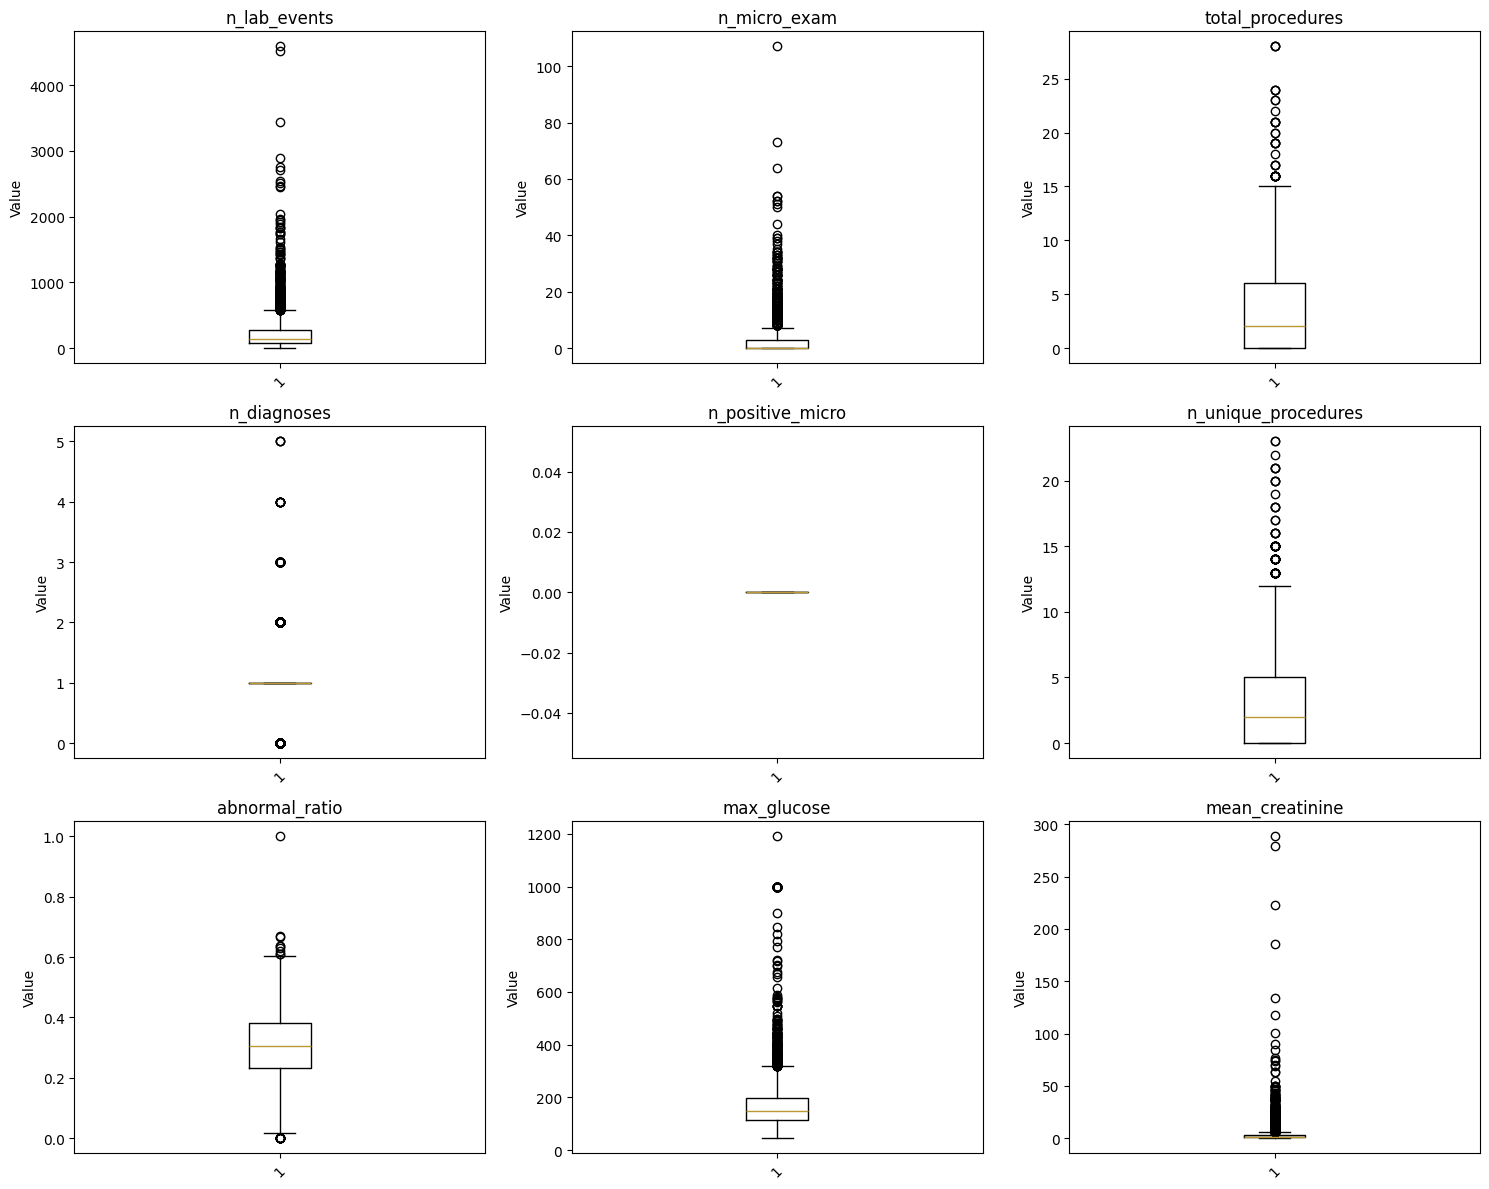

In [10]:
# Visualize distributions and outliers for key features
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

key_features = numeric_cols[:9] if len(numeric_cols) >= 9 else numeric_cols

for i, col in enumerate(key_features):
    if i < len(axes):
        axes[i].boxplot(df_clean[col].dropna())
        axes[i].set_title(f'{col}')
        axes[i].set_ylabel('Value')
        axes[i].tick_params(axis='x', rotation=45)

# Hide unused subplots
for i in range(len(key_features), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(data_path.parent / 'plots' / '1.2.1_outliers_boxplot.png', dpi=150, bbox_inches='tight')
print("✓ Saved outlier boxplots to plots/1.2.1_outliers_boxplot.png")
plt.show()


In [11]:
# Cap outliers instead of removing (preserve data)
# For features with many outliers, we'll cap at 99th percentile
df_prepared = df_clean.copy()

print("\nCapping outliers at 1st and 99th percentiles...")
for col in numeric_cols:
    if col in df_prepared.columns:
        lower_percentile = df_prepared[col].quantile(0.01)
        upper_percentile = df_prepared[col].quantile(0.99)
        
        original_outliers = ((df_prepared[col] < lower_percentile) | (df_prepared[col] > upper_percentile)).sum()
        
        df_prepared[col] = df_prepared[col].clip(lower=lower_percentile, upper=upper_percentile)
        
        if original_outliers > 0:
            print(f"  {col}: capped {original_outliers} outliers (1st-99th percentile: {lower_percentile:.2f} - {upper_percentile:.2f})")

print("\nOutlier capping completed!")



Capping outliers at 1st and 99th percentiles...
  n_lab_events: capped 44 outliers (1st-99th percentile: 0.00 - 1259.36)
  n_micro_exam: capped 37 outliers (1st-99th percentile: 0.00 - 28.00)
  total_procedures: capped 32 outliers (1st-99th percentile: 0.00 - 15.00)
  n_diagnoses: capped 11 outliers (1st-99th percentile: 0.00 - 3.00)
  n_unique_procedures: capped 32 outliers (1st-99th percentile: 0.00 - 14.00)
  abnormal_ratio: capped 87 outliers (1st-99th percentile: 0.04 - 0.56)
  max_glucose: capped 40 outliers (1st-99th percentile: 84.00 - 1000.00)
  mean_creatinine: capped 75 outliers (1st-99th percentile: 0.50 - 36.55)
  mean_hemoglobin: capped 83 outliers (1st-99th percentile: 7.72 - 15.80)
  age: capped 53 outliers (1st-99th percentile: 38.91 - 91.00)
  days_since_last_admission_x: capped 7 outliers (1st-99th percentile: 4.00 - 2690.00)
  n_total_admissions: capped 11 outliers (1st-99th percentile: 1.00 - 3.00)
  days_since_last_admission_y: capped 7 outliers (1st-99th percent

## 4. Data Transformations: Z-Normalization


In [12]:
# Prepare data for normalization (exclude subject_id and categorical columns)
features_to_normalize = [col for col in numeric_cols if col in df_prepared.columns]

print(f"Features to normalize: {len(features_to_normalize)}")
print(f"Features: {features_to_normalize}")

# Store subject_id and categorical columns
subject_ids = df_prepared['subject_id'].copy()
categorical_data = df_prepared[['gender']].copy() if 'gender' in df_prepared.columns else pd.DataFrame()

# Extract features for normalization
X = df_prepared[features_to_normalize].copy()

# Apply z-normalization (standardization)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X_normalized_df = pd.DataFrame(X_normalized, columns=features_to_normalize, index=df_prepared.index)

print("\nNormalization statistics:")
print(f"  Mean (should be ~0): {X_normalized_df.mean().abs().max():.6f}")
print(f"  Std (should be ~1): {X_normalized_df.std().min():.4f} - {X_normalized_df.std().max():.4f}")

# Reconstruct dataframe
df_normalized = pd.concat([subject_ids, X_normalized_df, categorical_data], axis=1)

print(f"\nNormalized dataset shape: {df_normalized.shape}")
print(f"Features normalized: {len(features_to_normalize)}")


Features to normalize: 14
Features: ['n_lab_events', 'n_micro_exam', 'total_procedures', 'n_diagnoses', 'n_positive_micro', 'n_unique_procedures', 'abnormal_ratio', 'max_glucose', 'mean_creatinine', 'mean_hemoglobin', 'age', 'days_since_last_admission_x', 'n_total_admissions', 'days_since_last_admission_y']

Normalization statistics:
  Mean (should be ~0): 0.000000
  Std (should be ~1): 0.0000 - 1.0013

Normalized dataset shape: (4392, 16)
Features normalized: 14


## 5. Feature Selection: Remove Redundant Features


✓ Saved correlation matrix to plots/1.2.1_correlation_matrix.png


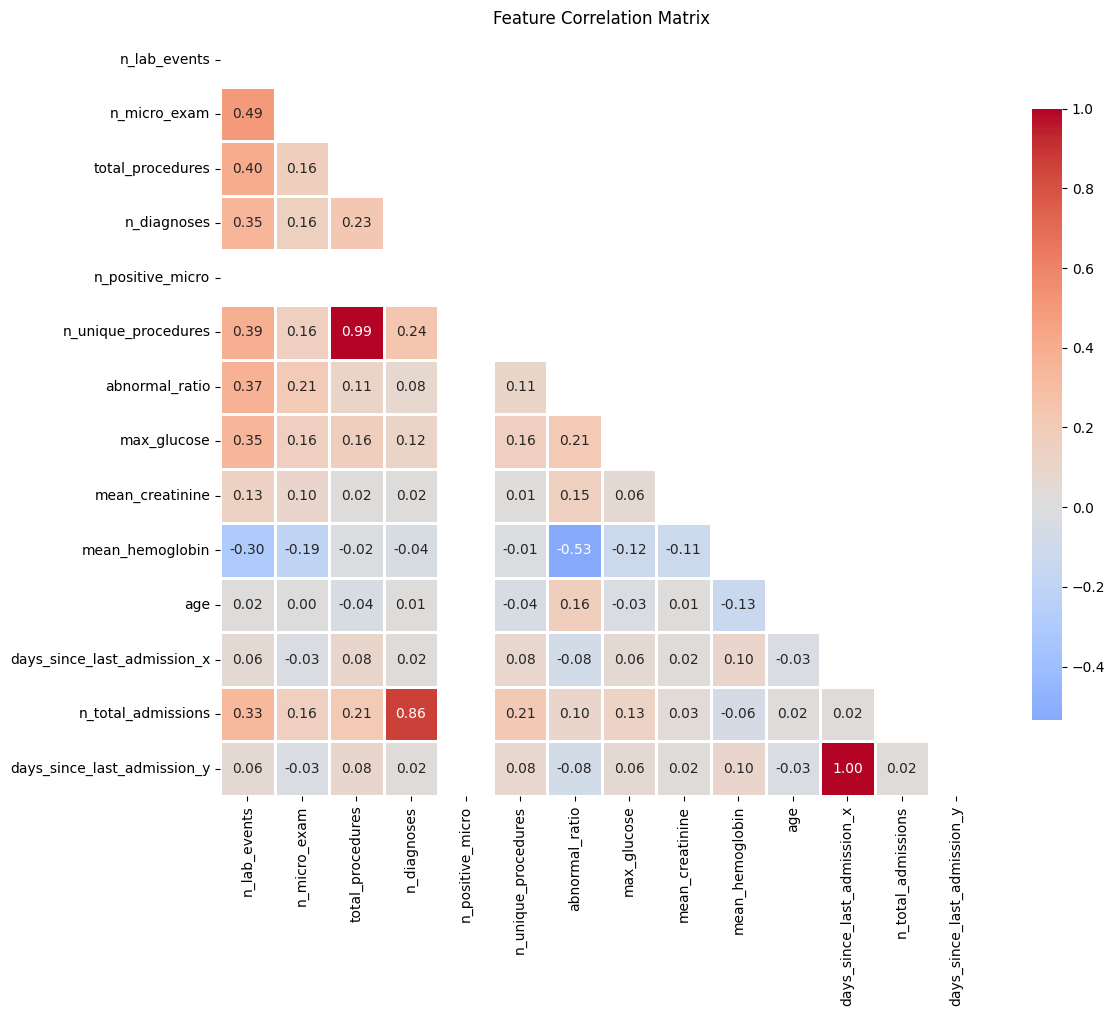

In [13]:
# Compute pairwise correlations
correlation_matrix = X_normalized_df.corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig(data_path.parent / 'plots' / '1.2.1_correlation_matrix.png', dpi=150, bbox_inches='tight')
print("✓ Saved correlation matrix to plots/1.2.1_correlation_matrix.png")
plt.show()


In [14]:
# Identify highly correlated feature pairs (threshold: 0.9)
print("="*80)
print("HIGHLY CORRELATED FEATURE PAIRS (|correlation| > 0.9)")
print("="*80)

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.9:
            high_corr_pairs.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': corr_val
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    print(high_corr_df)
    
    # Remove one feature from each highly correlated pair
    features_to_remove = set()
    for pair in high_corr_pairs:
        # Keep the first feature, remove the second
        features_to_remove.add(pair['Feature 2'])
    
    print(f"\nFeatures to remove due to high correlation: {list(features_to_remove)}")
else:
    print("No highly correlated feature pairs found (threshold: 0.9)")
    features_to_remove = set()


HIGHLY CORRELATED FEATURE PAIRS (|correlation| > 0.9)
                     Feature 1                    Feature 2  Correlation
0             total_procedures          n_unique_procedures     0.990596
1  days_since_last_admission_x  days_since_last_admission_y     1.000000

Features to remove due to high correlation: ['n_unique_procedures', 'days_since_last_admission_y']


In [15]:
# Remove redundant features
final_features = [col for col in features_to_normalize if col not in features_to_remove]

# Also keep subject_id and categorical columns
if 'gender' in df_normalized.columns:
    final_features.append('gender')

df_final = df_normalized[['subject_id'] + final_features].copy()

print(f"Final feature set: {len(final_features)} features")
print(f"Features removed: {len(features_to_remove)}")
print(f"\nFinal features:")
for i, feat in enumerate(final_features, 1):
    print(f"  {i}. {feat}")

print(f"\nFinal dataset shape: {df_final.shape}")


Final feature set: 13 features
Features removed: 2

Final features:
  1. n_lab_events
  2. n_micro_exam
  3. total_procedures
  4. n_diagnoses
  5. n_positive_micro
  6. abnormal_ratio
  7. max_glucose
  8. mean_creatinine
  9. mean_hemoglobin
  10. age
  11. days_since_last_admission_x
  12. n_total_admissions
  13. gender

Final dataset shape: (4392, 14)


## 6. Final Data Quality Check


In [16]:
print("="*80)
print("FINAL DATA QUALITY CHECK")
print("="*80)

print(f"\nDataset shape: {df_final.shape}")
print(f"Subjects: {len(df_final):,}")
print(f"Features: {len(df_final.columns) - 1}")  # Excluding subject_id

print("\nMissing values:")
missing_final = df_final.isna().sum()
print(missing_final[missing_final > 0] if missing_final.sum() > 0 else "  None")

print("\nDuplicate records:")
duplicates = df_final.duplicated(subset=[col for col in df_final.columns if col != 'subject_id']).sum()
print(f"  {duplicates} duplicate records found")

print("\nFeature statistics (normalized):")
numeric_final = [col for col in final_features if col != 'gender']
print(df_final[numeric_final].describe())


FINAL DATA QUALITY CHECK

Dataset shape: (4392, 14)
Subjects: 4,392
Features: 13

Missing values:
days_since_last_admission_x    4001
dtype: int64

Duplicate records:
  142 duplicate records found

Feature statistics (normalized):
       n_lab_events  n_micro_exam  total_procedures   n_diagnoses  \
count  4.392000e+03  4.392000e+03       4392.000000  4.392000e+03   
mean  -1.294249e-17 -1.294249e-17          0.000000 -1.488386e-16   
std    1.000114e+00  1.000114e+00          1.000114  1.000114e+00   
min   -9.702322e-01 -5.089741e-01         -0.990515 -2.571360e+00   
25%   -6.223170e-01 -5.089741e-01         -0.990515 -1.405780e-01   
50%   -3.421775e-01 -5.089741e-01         -0.383773 -1.405780e-01   
75%    2.813588e-01  1.007952e-01          0.829711 -1.405780e-01   
max    4.720034e+00  5.182206e+00          3.560051  4.720986e+00   

       n_positive_micro  abnormal_ratio   max_glucose  mean_creatinine  \
count            4392.0    4.392000e+03  4.392000e+03     4.392000e+03   

## 7. Save Prepared Patient Profile


In [17]:
# Convert subject_id to integer (nullable)
if 'subject_id' in df_final.columns:
    df_final['subject_id'] = df_final['subject_id'].astype('Int64')

# Save prepared dataset
output_file = data_path / '1.2.1_prepared_patient_profile.csv'
df_final.to_csv(output_file, index=False)
print(f"✓ Saved prepared patient profile to: {output_file}")
print(f"  Subjects: {len(df_final):,}")
print(f"  Features: {len(final_features)}")
print(f"  File size: {output_file.stat().st_size / 1024:.2f} KB")

print("\n" + "="*80)
print("DATA PREPARATION COMPLETE")
print("="*80)
print("The dataset is now ready for clustering analysis!")
print(f"  - Missing values handled")
print(f"  - Outliers capped")
print(f"  - Features normalized (z-score)")
print(f"  - Redundant features removed")
print(f"  - Final feature count: {len(final_features)}")


✓ Saved prepared patient profile to: /Users/alexandermittet/Library/Mobile Documents/com~apple~CloudDocs/uni_life/UniPi DAD/data_analytics_4_health_unipi/Data/1.2.1_prepared_patient_profile.csv
  Subjects: 4,392
  Features: 13
  File size: 934.22 KB

DATA PREPARATION COMPLETE
The dataset is now ready for clustering analysis!
  - Missing values handled
  - Outliers capped
  - Features normalized (z-score)
  - Redundant features removed
  - Final feature count: 13
